In [ ]:
#load in data 

In [15]:
import os
import requests
import zipfile
import io
import glob
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:

def download_acs_1year_person_data(state_abbr="ca", years=[2018,2019, 2021, 2022, 2023, 2024]):
    """
    Downloads 1-Year ACS PUMS person files. 
    """
    for year in years:
        url = f"https://www2.census.gov/programs-surveys/acs/data/pums/{year}/1-Year/csv_p{state_abbr}.zip"
        dest_folder = f"CA-ALL-DATA/data_persons_{state_abbr}_1yr/{year}"
        os.makedirs(dest_folder, exist_ok=True)
        
        print(f"Downloading {year} 1-Year data...")
        try:
            r = requests.get(url, stream=True)
            r.raise_for_status()
            with zipfile.ZipFile(io.BytesIO(r.content)) as z:
                z.extractall(dest_folder)
                print(f"Done: {year}")
        except Exception as e:
            print(f"Skipping {year}: {e}")

# We only run once 
#download_acs_1year_person_data()

Done: 2018
Done: 2019
Done: 2021
Done: 2022
Done: 2023
Done: 2024


In [5]:
# Looking for consistent/inconsistent Columns 
base_path = "CA-ALL-DATA/data_persons_ca_1yr"
years = [2018, 2019, 2021, 2022, 2023, 2024]
column_sets = {} # Using a dict to keep track of which set belongs to which year

# 1. Scan headers and store sets
for year in years:
    search_path = os.path.join(base_path, str(year), "*.csv")
    files = glob.glob(search_path)
    
    if files:
        header = pd.read_csv(files[0], nrows=0)
        # Store the set of columns for this specific year
        column_sets[year] = set(header.columns)

# 2. Find the intersection
common_cols = set.intersection(*column_sets.values())

# 3. Filter the common columns (No PWG/No F)
final_cols = sorted([c for c in common_cols if not c.startswith("PWG") and not c.startswith("F")])

print(f"\n--- Intersection Complete! ---")
print(f"Total common columns found: {len(final_cols)}")
print("-" * 50)

# 4. Indicate which columns were NOT common per year
for year in years:
    if year in column_sets:
        # Columns in this year that are NOT in the final common set
        # We  filter out PWG/F here so the list isn't cluttered with weights
        unique_to_year = [
            c for c in column_sets[year] 
            if c not in common_cols and not c.startswith("PWG") and not c.startswith("F")
        ]
        
        if unique_to_year:
            print(f"Year {year} had {len(unique_to_year)} unique/inconsistent columns:")
            print(f"  -> {sorted(unique_to_year)}")
        else:
            print(f"Year {year} has no unique columns (perfectly aligned).")


--- Intersection Complete! ---
Total common columns found: 117
--------------------------------------------------
Year 2018 had 9 unique/inconsistent columns:
  -> ['JWTR', 'MLPH', 'MLPI', 'MLPJ', 'MLPK', 'RELP', 'ST', 'VPS', 'WKW']
Year 2019 had 10 unique/inconsistent columns:
  -> ['HIMRKS', 'JWTRNS', 'MLPH', 'MLPI', 'MLPJ', 'MLPK', 'RELSHIPP', 'ST', 'VPS', 'WKWN']
Year 2021 had 9 unique/inconsistent columns:
  -> ['HIMRKS', 'JWTRNS', 'MLPH', 'MLPIK', 'MLPJ', 'RELSHIPP', 'ST', 'VPS', 'WKWN']
Year 2022 had 9 unique/inconsistent columns:
  -> ['HIMRKS', 'JWTRNS', 'MLPH', 'MLPIK', 'MLPJ', 'RELSHIPP', 'ST', 'VPS', 'WKWN']
Year 2023 had 9 unique/inconsistent columns:
  -> ['HIMRKS', 'JWTRNS', 'MLPH', 'MLPIK', 'MLPJ', 'RELSHIPP', 'STATE', 'VPS', 'WKWN']
Year 2024 had 8 unique/inconsistent columns:
  -> ['HIMRKS', 'JWTRNS', 'MLPHJ', 'MLPIK', 'RELSHIPP', 'STATE', 'VPSP', 'WKWN']


In [7]:

#Create a master csv removing users < 18 and > 65 along with cleaned rows only 
base_path = "CA-ALL-DATA/data_persons_ca_1yr"
master_output_path = "CA-ALL-DATA/acs_master_stacked_CA.csv"
years = [2018, 2019, 2021, 2022, 2023, 2024]

total_final_rows = 0

print(f"{'Year':<6} | {'Original':<10} | {'Removed':<10} | {'Filtered':<10}")
print("-" * 45)

for i, year in enumerate(years):
    search_path = os.path.join(base_path, str(year), "*.csv")
    files = glob.glob(search_path)
    
    if files:
        df = pd.read_csv(files[0], usecols=final_cols, low_memory=False)
        original_count = len(df)
        
        # Age Filter
        df_filtered = df[(df['AGEP'] >= 18) & (df['AGEP'] <= 65)].copy()
        filtered_count = len(df_filtered)
        removed_count = original_count - filtered_count
        
        #  Add Year column
        df_filtered.insert(0, 'SURVEY_YEAR', year)
        
        # 4. Save/Stack
        if i == 0:
            df_filtered.to_csv(master_output_path, index=False, mode='w')
        else:
            df_filtered.to_csv(master_output_path, index=False, mode='a', header=False)
            
        # 5. Printout
        print(f"{year:<6} | {original_count:<10,} | {removed_count:<10,} | {filtered_count:<10,}")
        
        total_final_rows += filtered_count
        
        # Explicit memory management
        del df
        del df_filtered

print("-" * 45)
print(f"COMPLETE: Master file contains {total_final_rows:,} total rows.")

Year   | Original   | Removed    | Filtered  
---------------------------------------------
2018   | 378,817    | 139,451    | 239,366   
2019   | 380,091    | 141,249    | 238,842   
2021   | 386,061    | 144,928    | 241,133   
2022   | 391,171    | 146,554    | 244,617   
2023   | 392,318    | 148,683    | 243,635   
2024   | 393,725    | 150,020    | 243,705   
---------------------------------------------
COMPLETE: Master file contains 1,451,298 total rows.


In [18]:

df_main = pd.read_csv('/home/ialtamir/teams/z5/Ingrid/CA-ALL-DATA/acs_master_stacked_CA.csv')
print(df_main.shape)

(1451298, 118)


In [19]:
#We are categorizing POVIP to poverty risk score based on the following metrics 
def categorize_poverty(val):
    if val <= 50: return 3   # Deep Poverty
    if val <= 100: return 2  # Poverty
    if val <= 200: return 1  # Near Poverty
    return 0                # Stable

df_main['poverty_risk_score'] = df_main['POVPIP'].apply(categorize_poverty)

/tmp/ipykernel_370/189334685.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df_main, x='poverty_risk_score', palette='viridis_r', edgecolor='black')


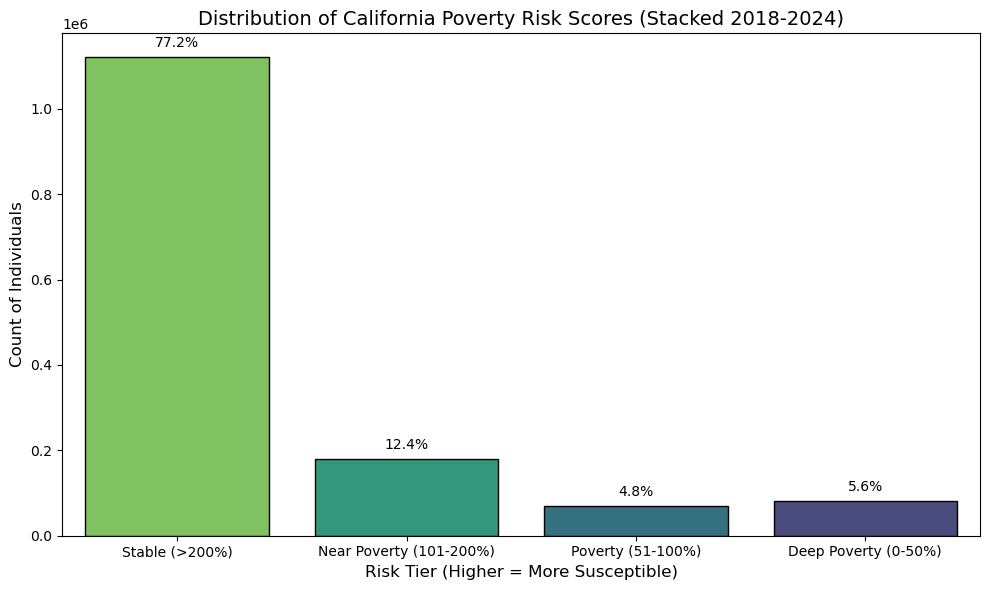

In [20]:
plt.figure(figsize=(10, 6))
labels = ['Stable (>200%)', 'Near Poverty (101-200%)', 'Poverty (51-100%)', 'Deep Poverty (0-50%)']
ax = sns.countplot(data=df_main, x='poverty_risk_score', palette='viridis_r', edgecolor='black')

plt.title('Distribution of California Poverty Risk Scores (Stacked 2018-2024)', fontsize=14)
plt.xlabel('Risk Tier (Higher = More Susceptible)', fontsize=12)
plt.ylabel('Count of Individuals', fontsize=12)
plt.xticks(ticks=[0,1,2,3], labels=labels)

# Add percentages on top of bars
total = len(df_main)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.tight_layout()
plt.savefig('poverty_risk_bins.png', dpi=150)
plt.show()

Text(0.5, 1.0, 'Mean Poverty Risk Score by Education Level (2018-2024)')

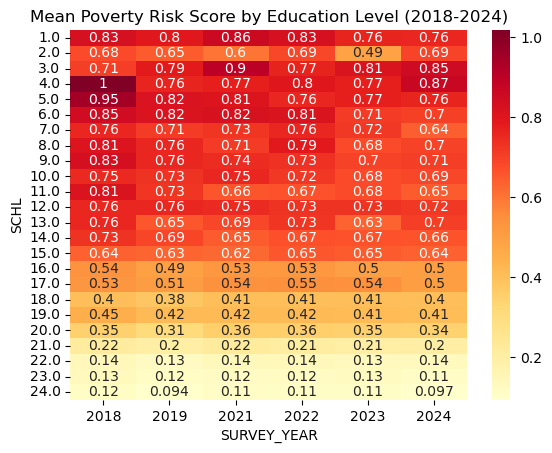

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Comparing Education level vs Poverty Risk over time
pivot_table = df_main.pivot_table(index='SCHL', columns='SURVEY_YEAR', values='poverty_risk_score', aggfunc='mean')
sns.heatmap(pivot_table, annot=True, cmap='YlOrRd')
plt.title("Mean Poverty Risk Score by Education Level (2018-2024)")

In [ ]:
#Lets note how we are moving from top 1.0 (no school) to bottom 24.0 (Doctorate) the colors are shifting from dark red to yellow 
# it indicates that school is a good predictor and it remains consistent for 2024 
# lets also note that 2024 looks a lot like 2023 and 2022, would be good to prioritize the weights in those years. 

In [22]:
puma_risk = df_main.groupby(['PUMA', 'SURVEY_YEAR'])['poverty_risk_score'].mean().unstack()
print(puma_risk.head())

SURVEY_YEAR      2018      2019      2021     2022      2023      2024
PUMA                                                                  
101          0.550562  0.468260  0.374010  0.48319  0.445545  0.436057
102          0.459623  0.406368  0.417852      NaN       NaN       NaN
103          0.206751  0.170301  0.204617      NaN       NaN       NaN
104          0.609103  0.554775  0.575448      NaN       NaN       NaN
105          0.241650  0.262704  0.290353      NaN       NaN       NaN


In [49]:
old_pumas = set(df_main[df_main['SURVEY_YEAR'] < 2022]['PUMA'].unique())
new_pumas = set(df_main[df_main['SURVEY_YEAR'] >= 2022]['PUMA'].unique())

print(f"PUMAs only in Old Data: {len(old_pumas - new_pumas)}")
print(f"PUMAs only in New Data: {len(new_pumas - old_pumas)}")
print(f"PUMAs that stayed the same: {len(old_pumas & new_pumas)}")


PUMAs only in Old Data: 85
PUMAs only in New Data: 101
PUMAs that stayed the same: 180


In [52]:
# Create a rough mapping of PUMA prefixes to major CA Regions
# (PUMA codes are usually geographically sequential)
def map_to_region(puma):
    p = int(puma)
    if p < 1500: return 'Northern CA / Sierras'
    if 1500 <= p < 3000: return 'Greater Bay Area'
    if 3000 <= p < 5000: return 'Central Valley'
    if 5000 <= p < 7000: return 'Central Coast'
    if 7000 <= p < 9000: return 'Los Angeles County'
    if 9000 <= p < 10000: return 'Inland Empire'
    if p >= 10000: return 'San Diego / Border'
    return 'Unknown'

# Apply the mapping
df_main['CA_Region'] = df_main['PUMA'].apply(map_to_region)

region_risk = df_main.groupby(['CA_Region', 'SURVEY_YEAR'])['poverty_risk_score'].mean().unstack()

print("=== Cleaned Regional Risk (No NaNs) ===")
print(region_risk)

=== Cleaned Regional Risk (No NaNs) ===
SURVEY_YEAR                2018      2019      2021      2022      2023  \
CA_Region                                                                 
Central Coast          0.389469  0.343165  0.363146  0.362127  0.341147   
Central Valley         0.454175  0.425894  0.464840  0.448348  0.433880   
Greater Bay Area       0.578720  0.533977  0.537689  0.526348  0.533620   
Inland Empire          0.395952  0.341141  0.354994  0.378784  0.361431   
Los Angeles County     0.358782  0.332780  0.342936  0.341893  0.327372   
Northern CA / Sierras  0.333042  0.305836  0.315787  0.343030  0.320434   
San Diego / Border     0.477166  0.405397  0.452677  0.426934  0.417670   

SURVEY_YEAR                2024  
CA_Region                        
Central Coast          0.340522  
Central Valley         0.419657  
Greater Bay Area       0.536067  
Inland Empire          0.349494  
Los Angeles County     0.325686  
Northern CA / Sierras  0.309547  
San Diego / 

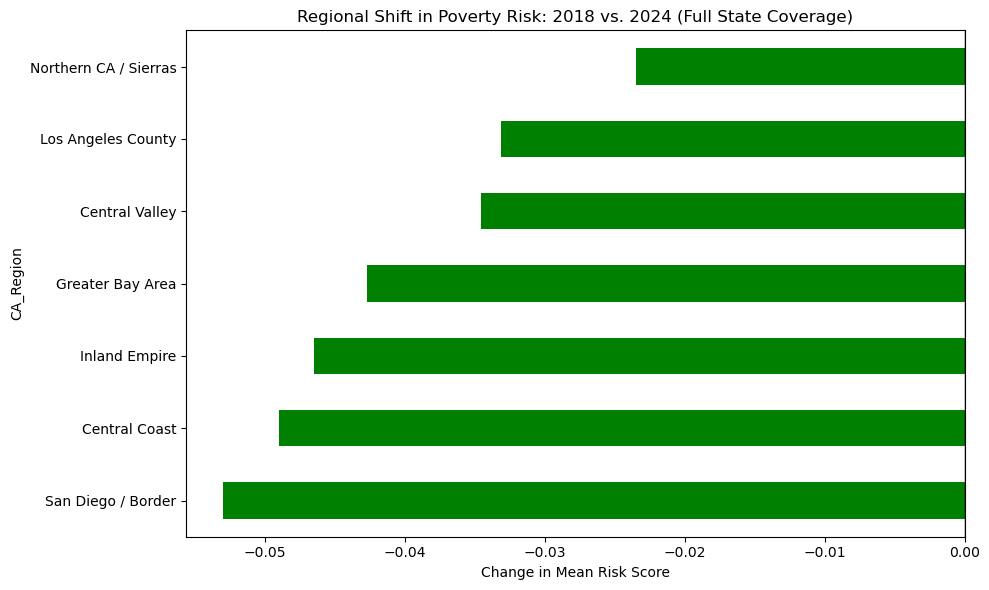

In [53]:
# 1. Map PUMAs to Regions first
df_main['CA_Region'] = df_main['PUMA'].apply(map_to_region)

# 2. Re-calculate risk by Region 
#calculates the average (mean) poverty risk score for each California region, broken down by survey year. 
region_risk = df_main.groupby(['CA_Region', 'SURVEY_YEAR'])['poverty_risk_score'].mean().unstack()

# 3. Calculate Delta between start and test-year
region_delta = (region_risk[2024] - region_risk[2018]).sort_values()

# 4. Plot
plt.figure(figsize=(10, 6))
colors = ['green' if x < 0 else 'red' for x in region_delta]
region_delta.plot(kind='barh', color=colors)

plt.title('Regional Shift in Poverty Risk: 2018 vs. 2024 (Full State Coverage)')
plt.xlabel('Change in Mean Risk Score')
plt.axvline(0, color='black', lw=1)
plt.tight_layout()
plt.show()

In [30]:
#!pip install joypy

Defaulting to user installation because normal site-packages is not writeable


<Figure size 1200x800 with 0 Axes>

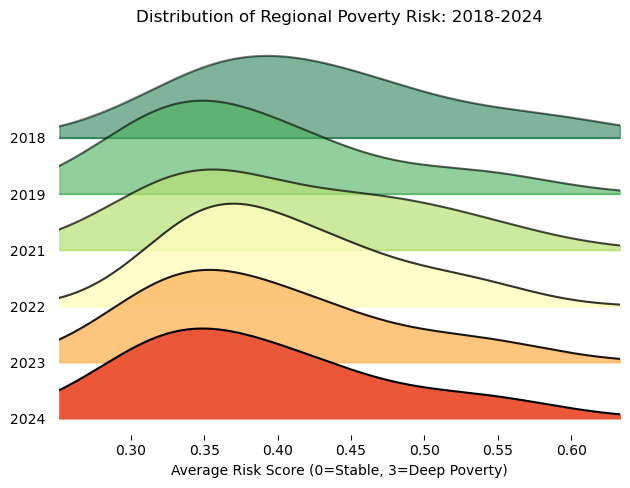

In [54]:
#how the "economic health" of California's different regions is distributed each year and see distribution of PUMA avg
# Notice that for every year from 2018 to 2024, the highest point of the "hump" sits between 0.3 and 0.4. 
#This indicates that most regions in California have a relatively low average risk

# The  for the joy" of a typical California region has remained constant
# A avg score of 1 means near poverty vs lower score most people in region are stable, small percentage 
import joypy

# Using the region_risk table ensures every year (2018-2024) 

plt.figure(figsize=(12, 8))
fig, axes = joypy.joyplot(region_risk.dropna(), 
                          colormap=plt.cm.RdYlGn_r, 
                          fade=True,
                          title="Distribution of Regional Poverty Risk: 2018-2024")

plt.xlabel("Average Risk Score (0=Stable, 3=Deep Poverty)")
plt.show()

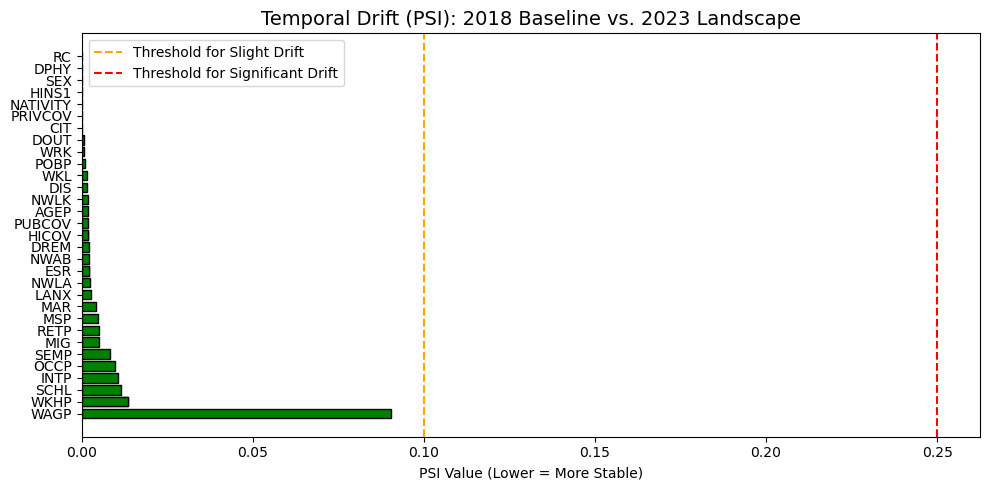

In [55]:

# ---  POPULATION STABILITY INDEX (PSI) ---
def calculate_psi(expected, actual, bins=10):
    """Calculates PSI between two distributions (e.g., 2018 vs 2023)"""
    # For categorical data or small unique counts
    if expected.dtype == 'object' or expected.nunique() < bins:
        exp_per = expected.value_counts(normalize=True).replace(0, 0.0001)
        act_per = actual.value_counts(normalize=True).reindex(exp_per.index, fill_value=0.0001)
    else:
        # For continuous data (Age, Hours worked, etc)
        counts_exp, bin_edges = np.histogram(expected.dropna(), bins=bins, density=True)
        counts_act, _ = np.histogram(actual.dropna(), bins=bin_edges, density=True)
        exp_per = counts_exp / counts_exp.sum() + 0.0001
        act_per = counts_act / counts_act.sum() + 0.0001
        
    psi_val = np.sum((act_per - exp_per) * np.log(act_per / exp_per))
    return psi_val

# Select key features to check for drift
features_to_check = ['AGEP', 'SCHL', 'ESR', 'HICOV', 'SEX', 'WKHP', 'CIT', 'MAR','MIG','MSP','NATIVITY','ESR','NWAB','NWLA','NWLK','OCCP','WKHP','WKL','WRK',
                    'INTP','RETP','SEMP','WAGP','HICOV','HINS1','PRIVCOV','PUBCOV','DIS','DOUT','DPHY','DREM','LANX','MIl','POBP','RC']
psi_results = []

# Compare 2018 (Baseline) to 2023 (Latest Training Year)
base_df = df_main[df_main['SURVEY_YEAR'] == 2018]
target_df = df_main[df_main['SURVEY_YEAR'] == 2023]

for feat in features_to_check:
    if feat in df_main.columns:
        psi_score = calculate_psi(base_df[feat], target_df[feat])
        psi_results.append({'Feature': feat, 'PSI': psi_score})

psi_df = pd.DataFrame(psi_results).sort_values(by='PSI', ascending=False)

# --- VISUAL 2: PSI DRIFT CHART ---
plt.figure(figsize=(10, 5))
colors = ['red' if x > 0.1 else 'green' for x in psi_df['PSI']]
plt.barh(psi_df['Feature'], psi_df['PSI'], color=colors, edgecolor='black')

plt.axvline(x=0.1, color='orange', linestyle='--', label='Threshold for Slight Drift')
plt.axvline(x=0.25, color='red', linestyle='--', label='Threshold for Significant Drift')
plt.title('Temporal Drift (PSI): 2018 Baseline vs. 2023 Landscape', fontsize=14)
plt.xlabel('PSI Value (Lower = More Stable)')
plt.legend()
plt.tight_layout()
plt.savefig('feature_stability_psi.png', dpi=150)
plt.show()

. The Population Stability Index (PSI)
The PSI is the professional way to measure "Temporal Drift."
PSI < 0.1: The feature distribution is stable (Safe for model).
PSI 0.1 - 0.25: There is a slight shift 
PSI > 0.25: Significant drift (The "Economic Landscape" for this feature has changed, meaning 2024 may need some adjustment)

In [ ]:
# balance data out 

In [56]:
df_main['poverty_risk_score'].value_counts()

poverty_risk_score
0    1120617
1     179524
3      80966
2      70191
Name: count, dtype: int64

In [ ]:
# we must downsample on the final dataset, use f1 score 
@ 